In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import scipy as sp
import pymc3 as pm
import pandas as pd
import sys
sys.path.append("../../codes/")
import utils
import plotutils

# plot configs
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("fivethirtyeight")

# 2D Gaussian Examples
$\newcommand{\rhat}{\widehat R}$

Similar to ``toymodel_gaussian.ipynb``, we showcase the merits and limitations of the $\rhat$ statistic along with rankplot. Here, we explore two cases. 

Our base example is an isotropic Gaussian with $ \mu = \begin{bmatrix}
0\\
0
\end{bmatrix}$ and $ \Sigma = \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}$. We inject two different Gaussian chains in this base model to understand the robustness of the $\rhat$ statistic and the rankplot diagnostic. 

First, we generate data from another Gaussian with same $\mu$ but a different $\Sigma = \begin{bmatrix}
1 & .9\\
.9 & 1
\end{bmatrix}$. This case tests how robust are these diagnostics to correlations. So, the diagonal terms are preserved but the off-diagonal terms are changed. 

Next, we generate data from another Gaussian with the same $\mu$ but a different $\Sigma = \begin{bmatrix}
1.5 & .5\\
.5 & 1.5
\end{bmatrix}$. This case is a more real-life case where both the diagonal and off-diagonal terms may be different. By comparing the two cases, we can also isolate the effects of the covariance matrix terms on our diagnostics. 

## Sample data for the isotropic Gaussian

<Figure size 1080x720 with 0 Axes>

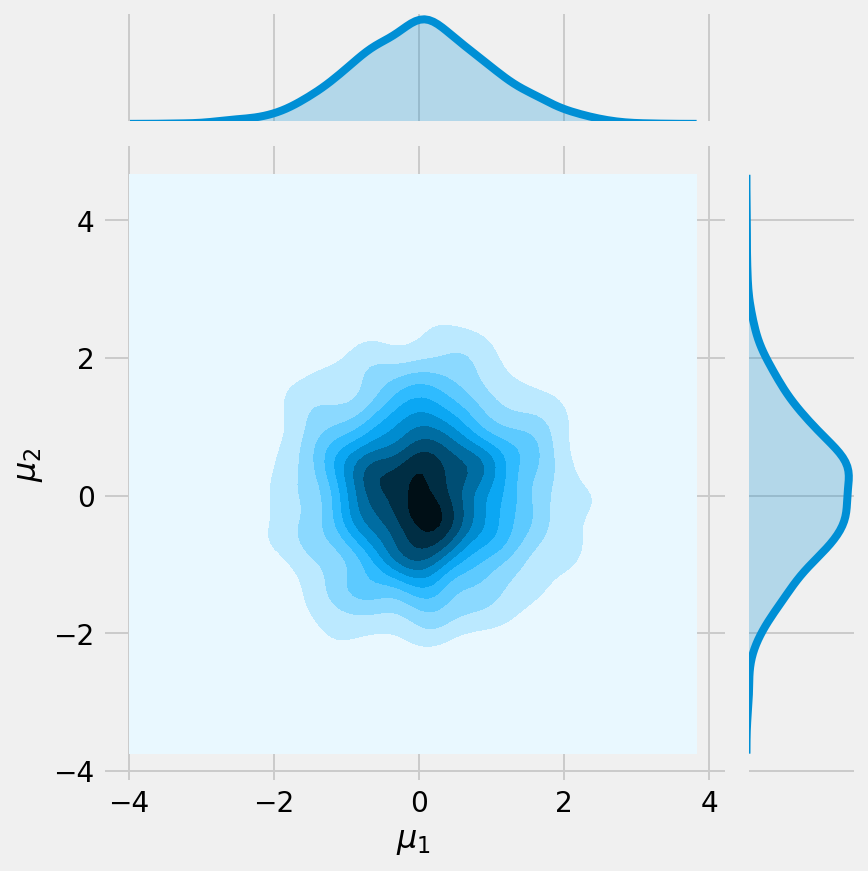

In [3]:
import seaborn as sns
seed = 42
np.random.seed(seed)
mean = np.array([0, 0])
sigma_iso = np.array([[1, 0], [0,1]])
data_isotropic = np.random.multivariate_normal(mean = mean, cov = sigma_iso, size=10_00)

fig = plt.figure(figsize=(15, 10))
f = sns.jointplot(data_isotropic[:,0], data_isotropic[:,1], kind = 'kde')
f.set_axis_labels(r'$\mu_1$', r'$\mu_2$', fontsize=16)

Let's now fit the data $y$ with the following model to be explored by our sampler:

$$
    \mu \sim \mathcal N \left(\begin{bmatrix}
0\\
0
\end{bmatrix}, \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}\right) \\
    y|\mu \sim \mathcal N \left(\begin{bmatrix}
0\\
0
\end{bmatrix}, \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}\right)
$$

In [4]:
params = ["mu"] # parameters to fit for
with pm.Model() as model_isotropic:
    mu = pm.MvNormal("mu", mean, sigma_iso, shape = 2)
    y_obs = pm.MvNormal("y_obs", mean, cov=sigma_iso, observed=data_isotropic)

with model_isotropic:
    trace_isotropic = pm.sample(1_000, chains=4, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:12<00:00, 626.53draws/s] 


Next, we check the traceplots to make sure that everything is fine:

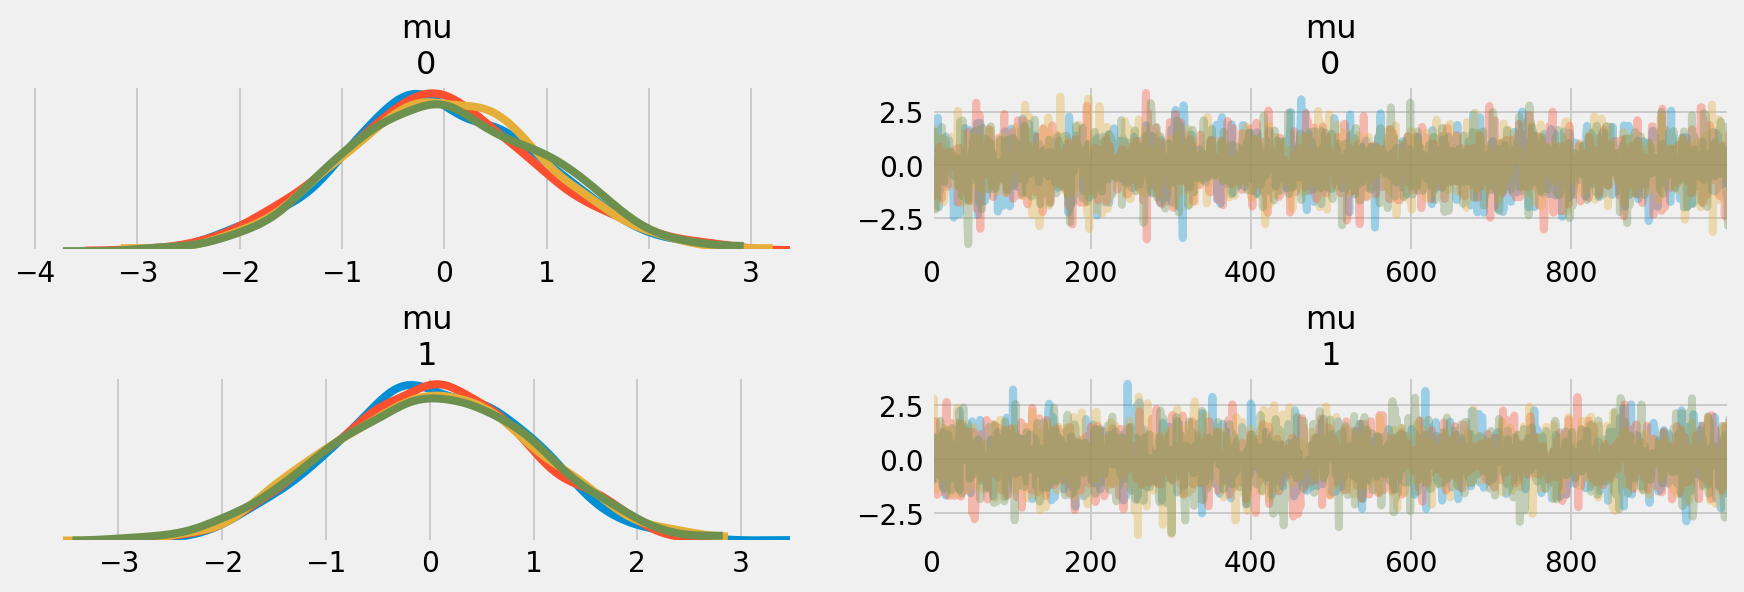

In [5]:
pm.traceplot(trace_isotropic)
plt.show()

This model looks well converged. 

Now, we will calculate the $\rhat$ statistic for the isotropic model, and show the rankplots:

In [6]:
def rhat_results(d):
    #
    # returns table of rhat values for parameter in dict (d)
    #
    index = [
        "standard",
        "split",
        "ranked",
        "folded"
    ]
    df_rhats = pd.DataFrame(index=index)
    for param_name, param_chains in d.items():
        rhat_standard = utils.rhat(param_chains, split=False)
        rhat_split = utils.rhat(param_chains, split=True)
        rhat_rank = utils.rank_rhat(param_chains)
        rhat_folded = utils.folded_split_rhat(param_chains)
        df_rhats[param_name] = [rhat_standard, rhat_split, rhat_rank, rhat_folded]

    return df_rhats

In [7]:
# extract trace array from pymc3's MultiTrace object
trace_dvar = np.array(trace_isotropic.get_values(params[0], combine=False)) 
trace_iso_dict = {}

for i in range(trace_dvar.shape[2]):
    string = "mu" + str(i + 1)
    trace_tmp = trace_dvar[:,:,i]
    trace_iso_dict[string] = trace_tmp
    
rhat_results(trace_iso_dict)

,mu1,mu2
standard,1.000134,0.999639
split,0.999664,1.000852
ranked,0.999667,1.000860
folded,0.999204,1.002970


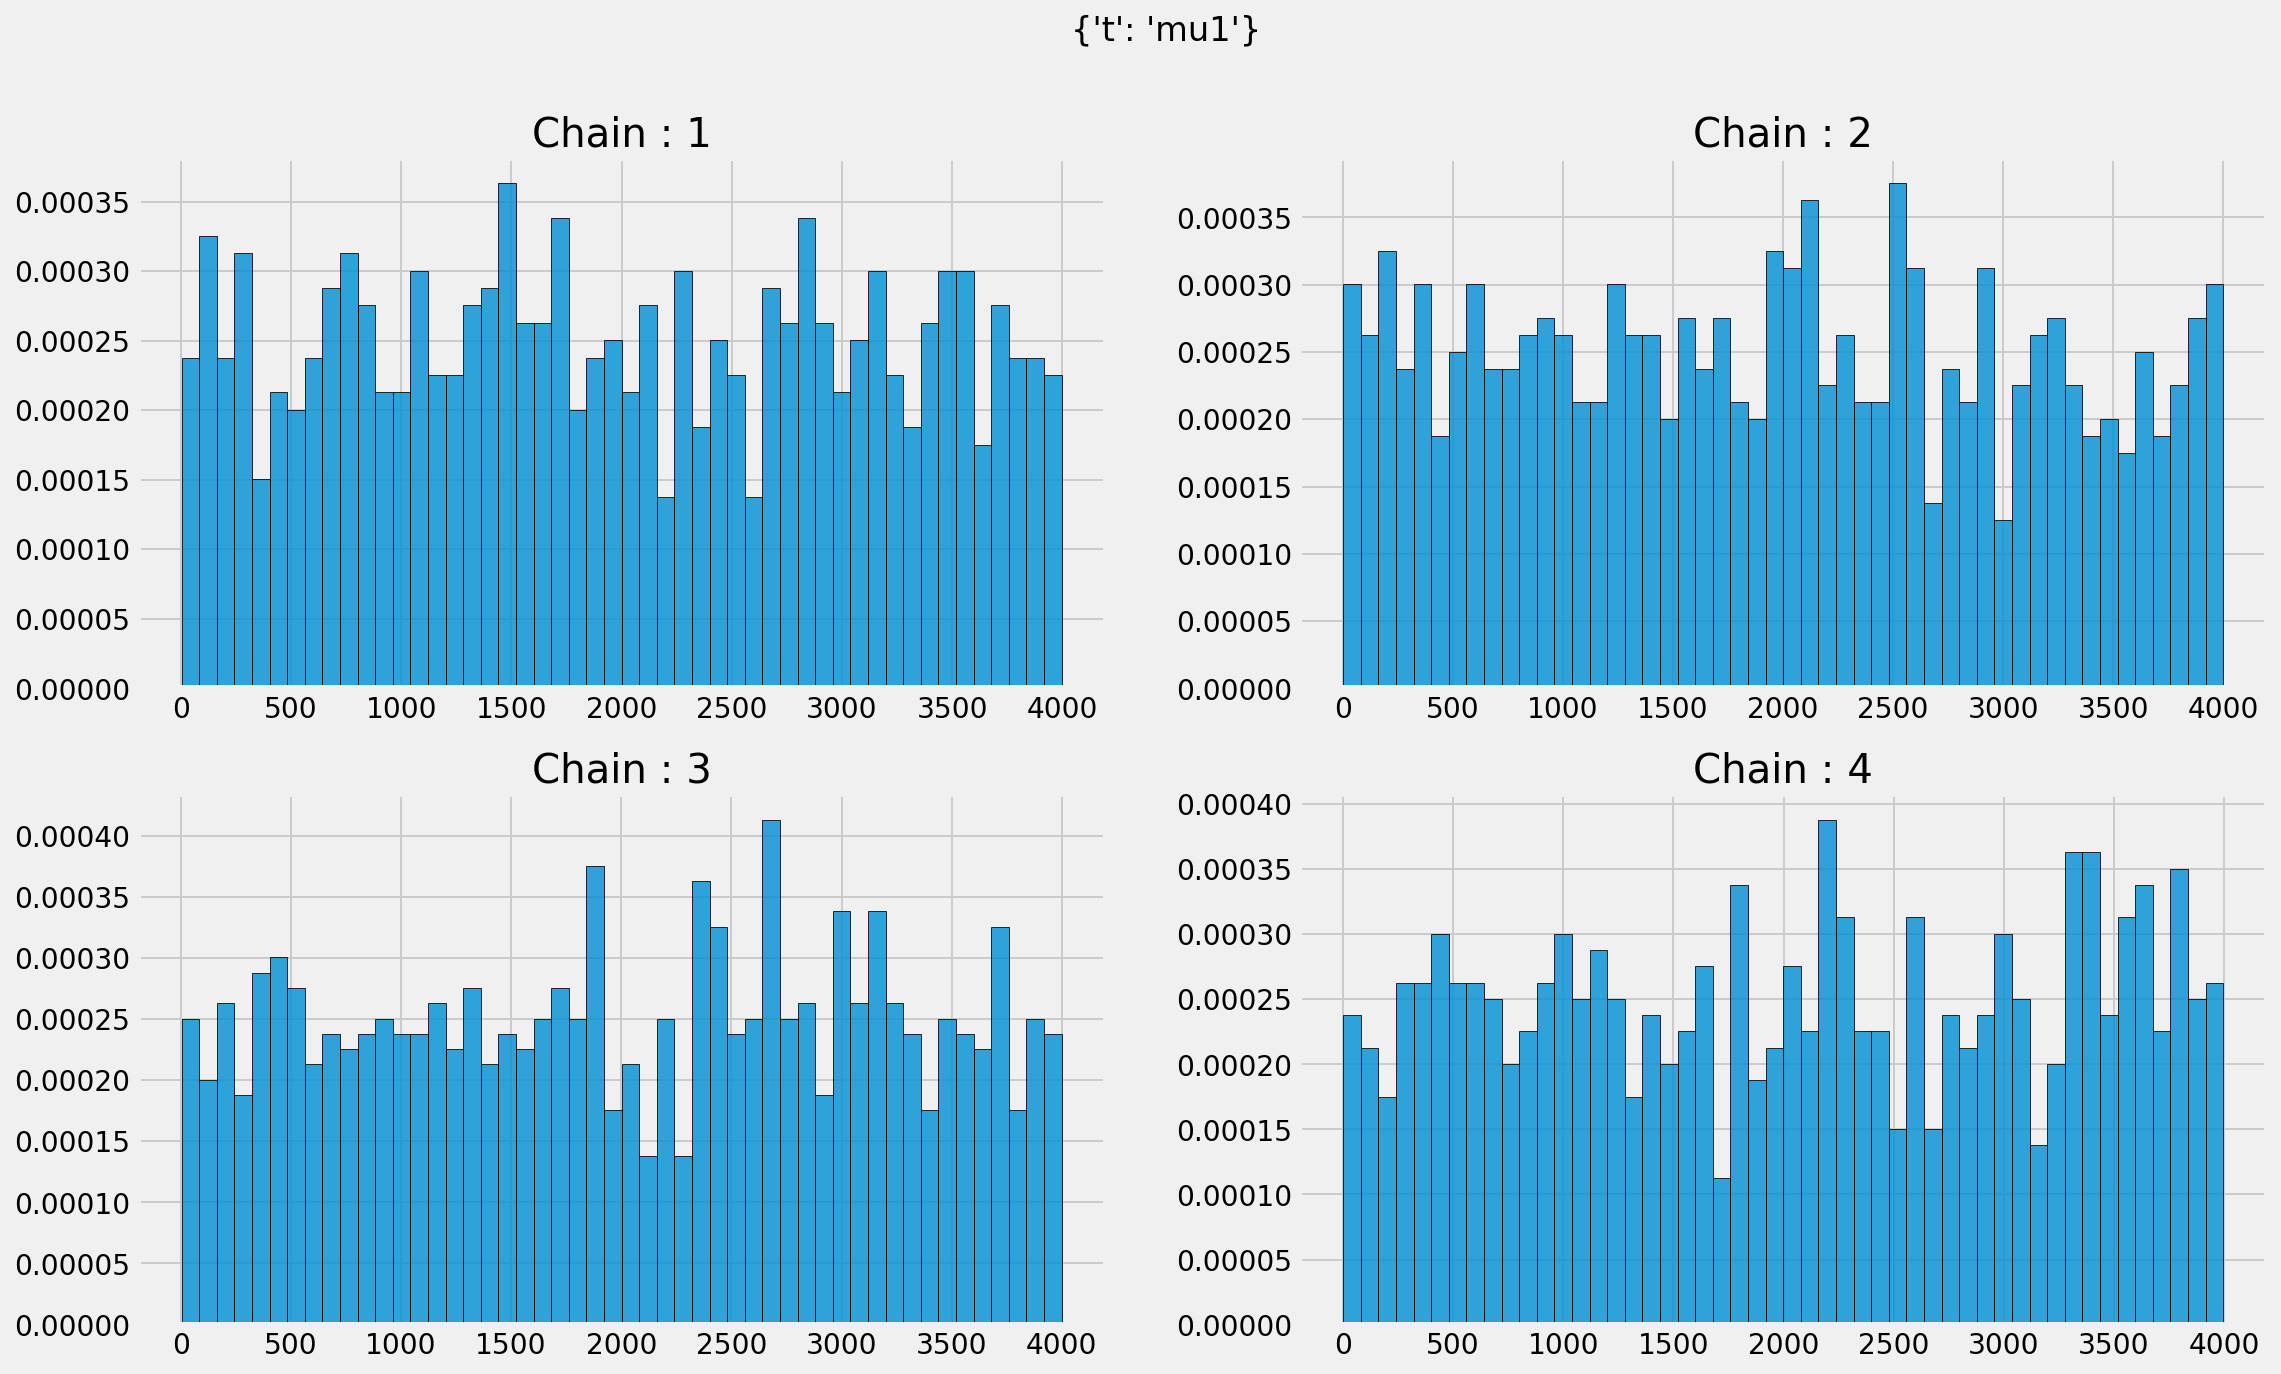

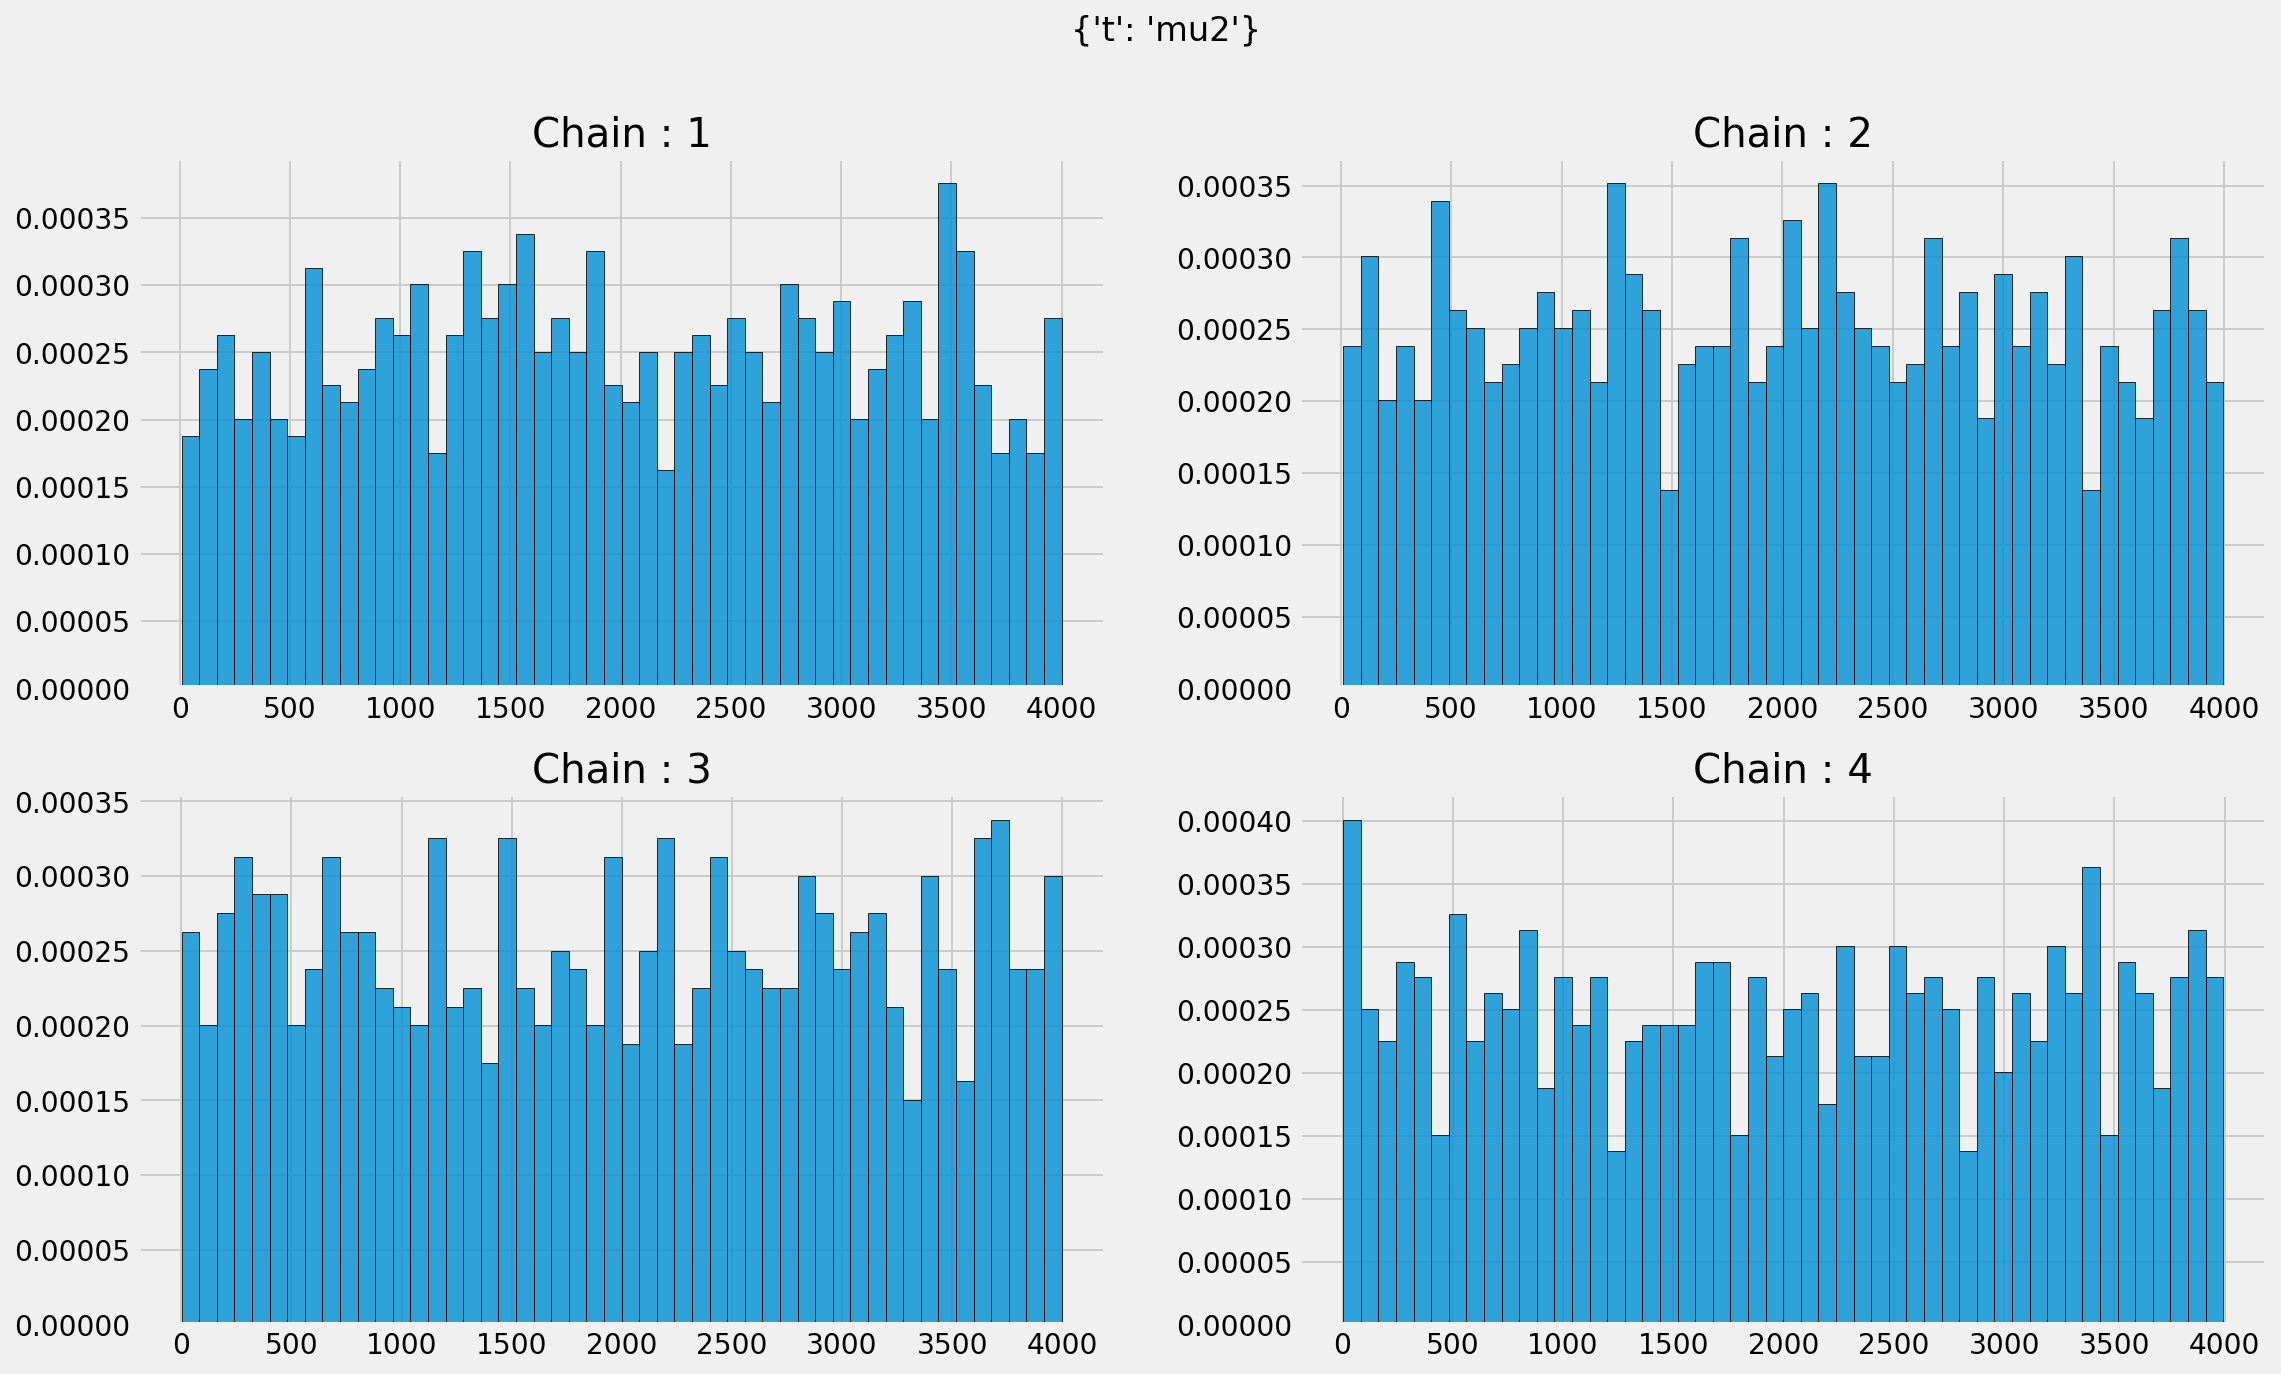

In [8]:
for i in range(trace_dvar.shape[2]):
    string = "mu" + str(i + 1)
    plotutils.rankplot(trace_dvar[:,:,i], 4, 2, 2, t = string)

We see that both the traditional and the ranked $\rhat$ statistics as well as the rankplots show well-mixing behaviour. 

## Case 1: Injecting a fake chain with a different correlation

Now, we inject a fake chain with a different correlation, i.e. different off-diagonal terms in the covariance matrix but the same diagonal terms. 

### Generate Correlated Gaussian

<Figure size 1080x720 with 0 Axes>

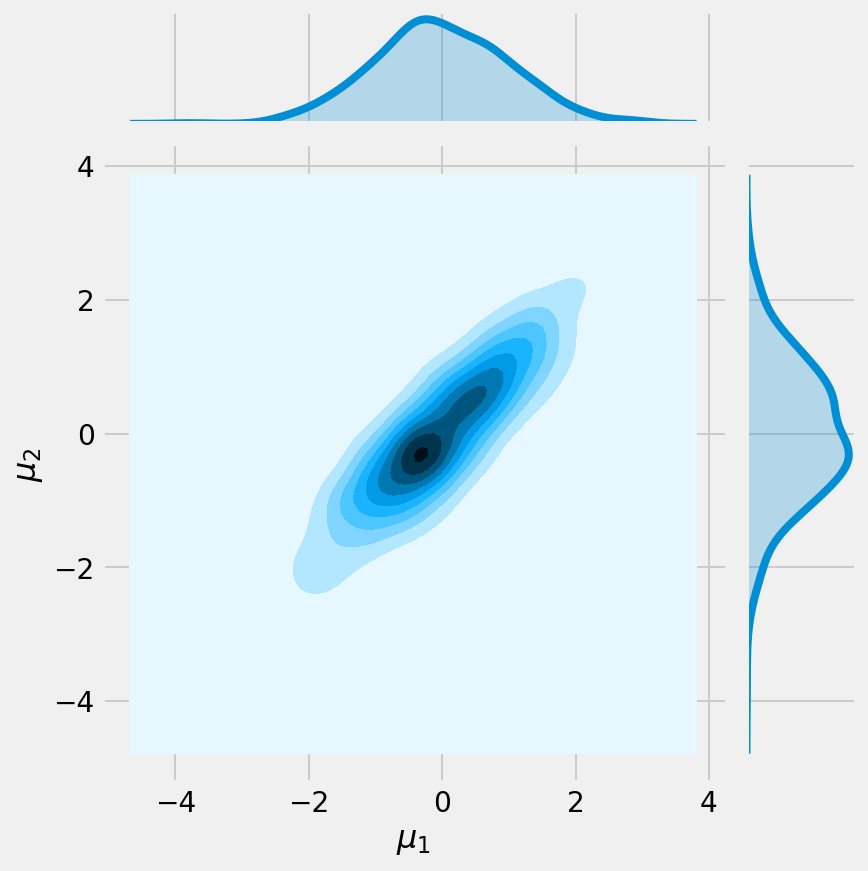

In [9]:
sigma_corr = np.array([[1, .9], [.9,1]])
data_corr = np.random.multivariate_normal(mean = mean, cov = sigma_corr, size=10_00)

fig = plt.figure(figsize=(15, 10))
f = sns.jointplot(data_corr[:,0], data_corr[:,1], kind = 'kde')
f.set_axis_labels(r'$\mu_1$', r'$\mu_2$', fontsize=16)

In [10]:
params = ["mu"] # parameters to fit for
with pm.Model() as model_corr:
    mu = pm.MvNormal(params[0], mean, sigma_corr, shape = 2)
    y_obs = pm.MvNormal("y_obs", mean, cov=sigma_corr, observed=data_corr)

with model_corr:
    trace_corr = pm.sample(1_000, chains=4, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:15<00:00, 501.93draws/s]


In [11]:
# extract trace array from pymc3's MultiTrace object
trace_dvar = np.array(trace_isotropic.get_values(params[0], combine=False)) 
# replace third chain of trace array with the first fake chain
trace_dvar[2, :] = np.array(trace_corr.get_values(params[0], combine=False))[0, :]

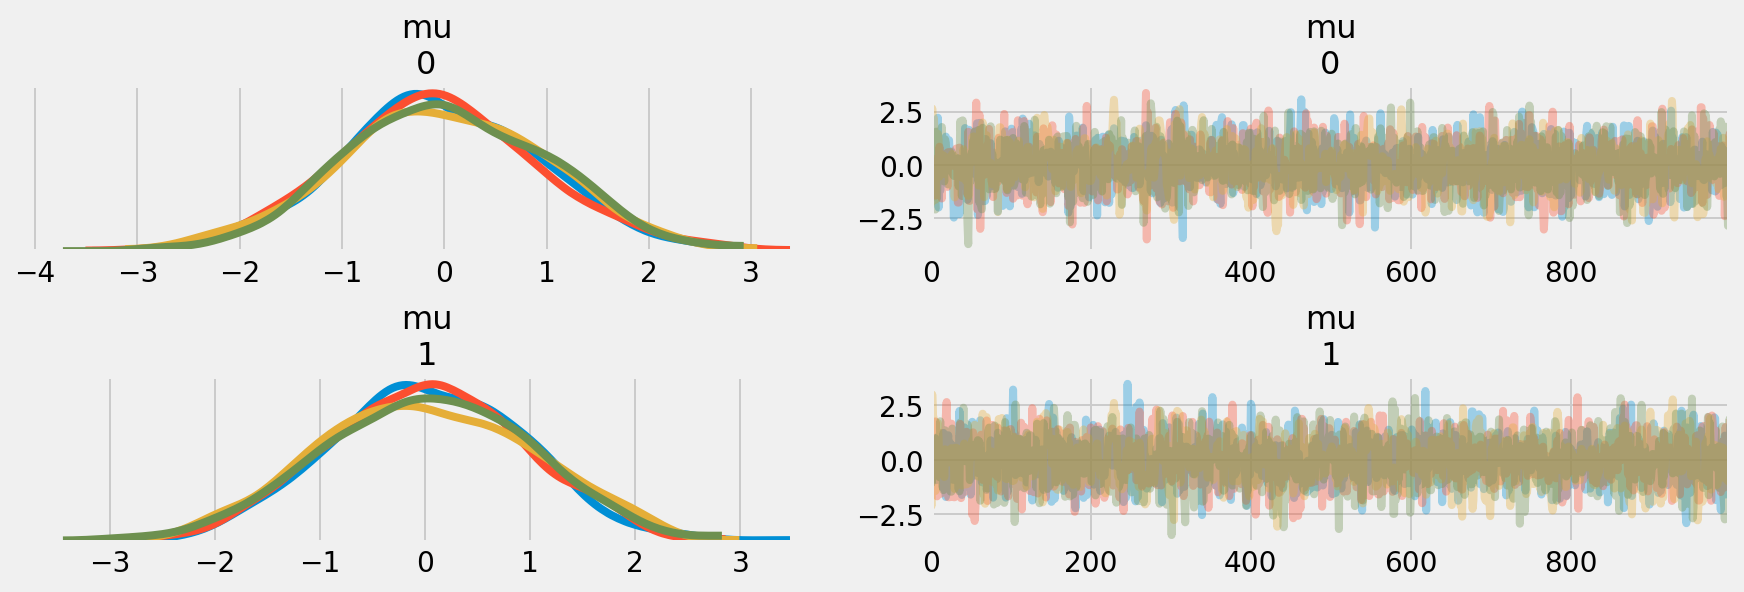

In [12]:
trace_dvar_dict = {params[0]:trace_dvar}
pm.traceplot(trace_dvar_dict)
plt.show()

We see that both $\mu$ values look similar and the traceplot would not tell us that there is a fake chain injected. 

### $\rhat$ and rankplot for Case 1

Now, we will calculate the $\rhat$ statistic and generate the rankplots:

In [14]:
trace_iso_injected_corr = {}
for i in range(trace_dvar.shape[2]):
    string = "mu" + str(i + 1)
    trace_tmp = trace_dvar[:,:,i]
    trace_iso_injected_corr[string] = trace_tmp
    
rhat_results(trace_iso_injected_corr)

,mu1,mu2
standard,1.000112,0.999660
split,1.000388,1.001290
ranked,1.000390,1.001319
folded,1.000027,1.003355


Here we see that the ranked or the folded $\rhat$ were not able to pick up on this injected chain at all. Given that we injected a really skewed 2D Gaussian, we can safely say that the newly defined ranked and folded rank $\rhat$ values cannot distinguish between isotropic and correlated cases. Hence, even this statistic can give the impression that the chains are sampling the same underlying distribution and that the chains converged, whereas in reality this may not be the case.

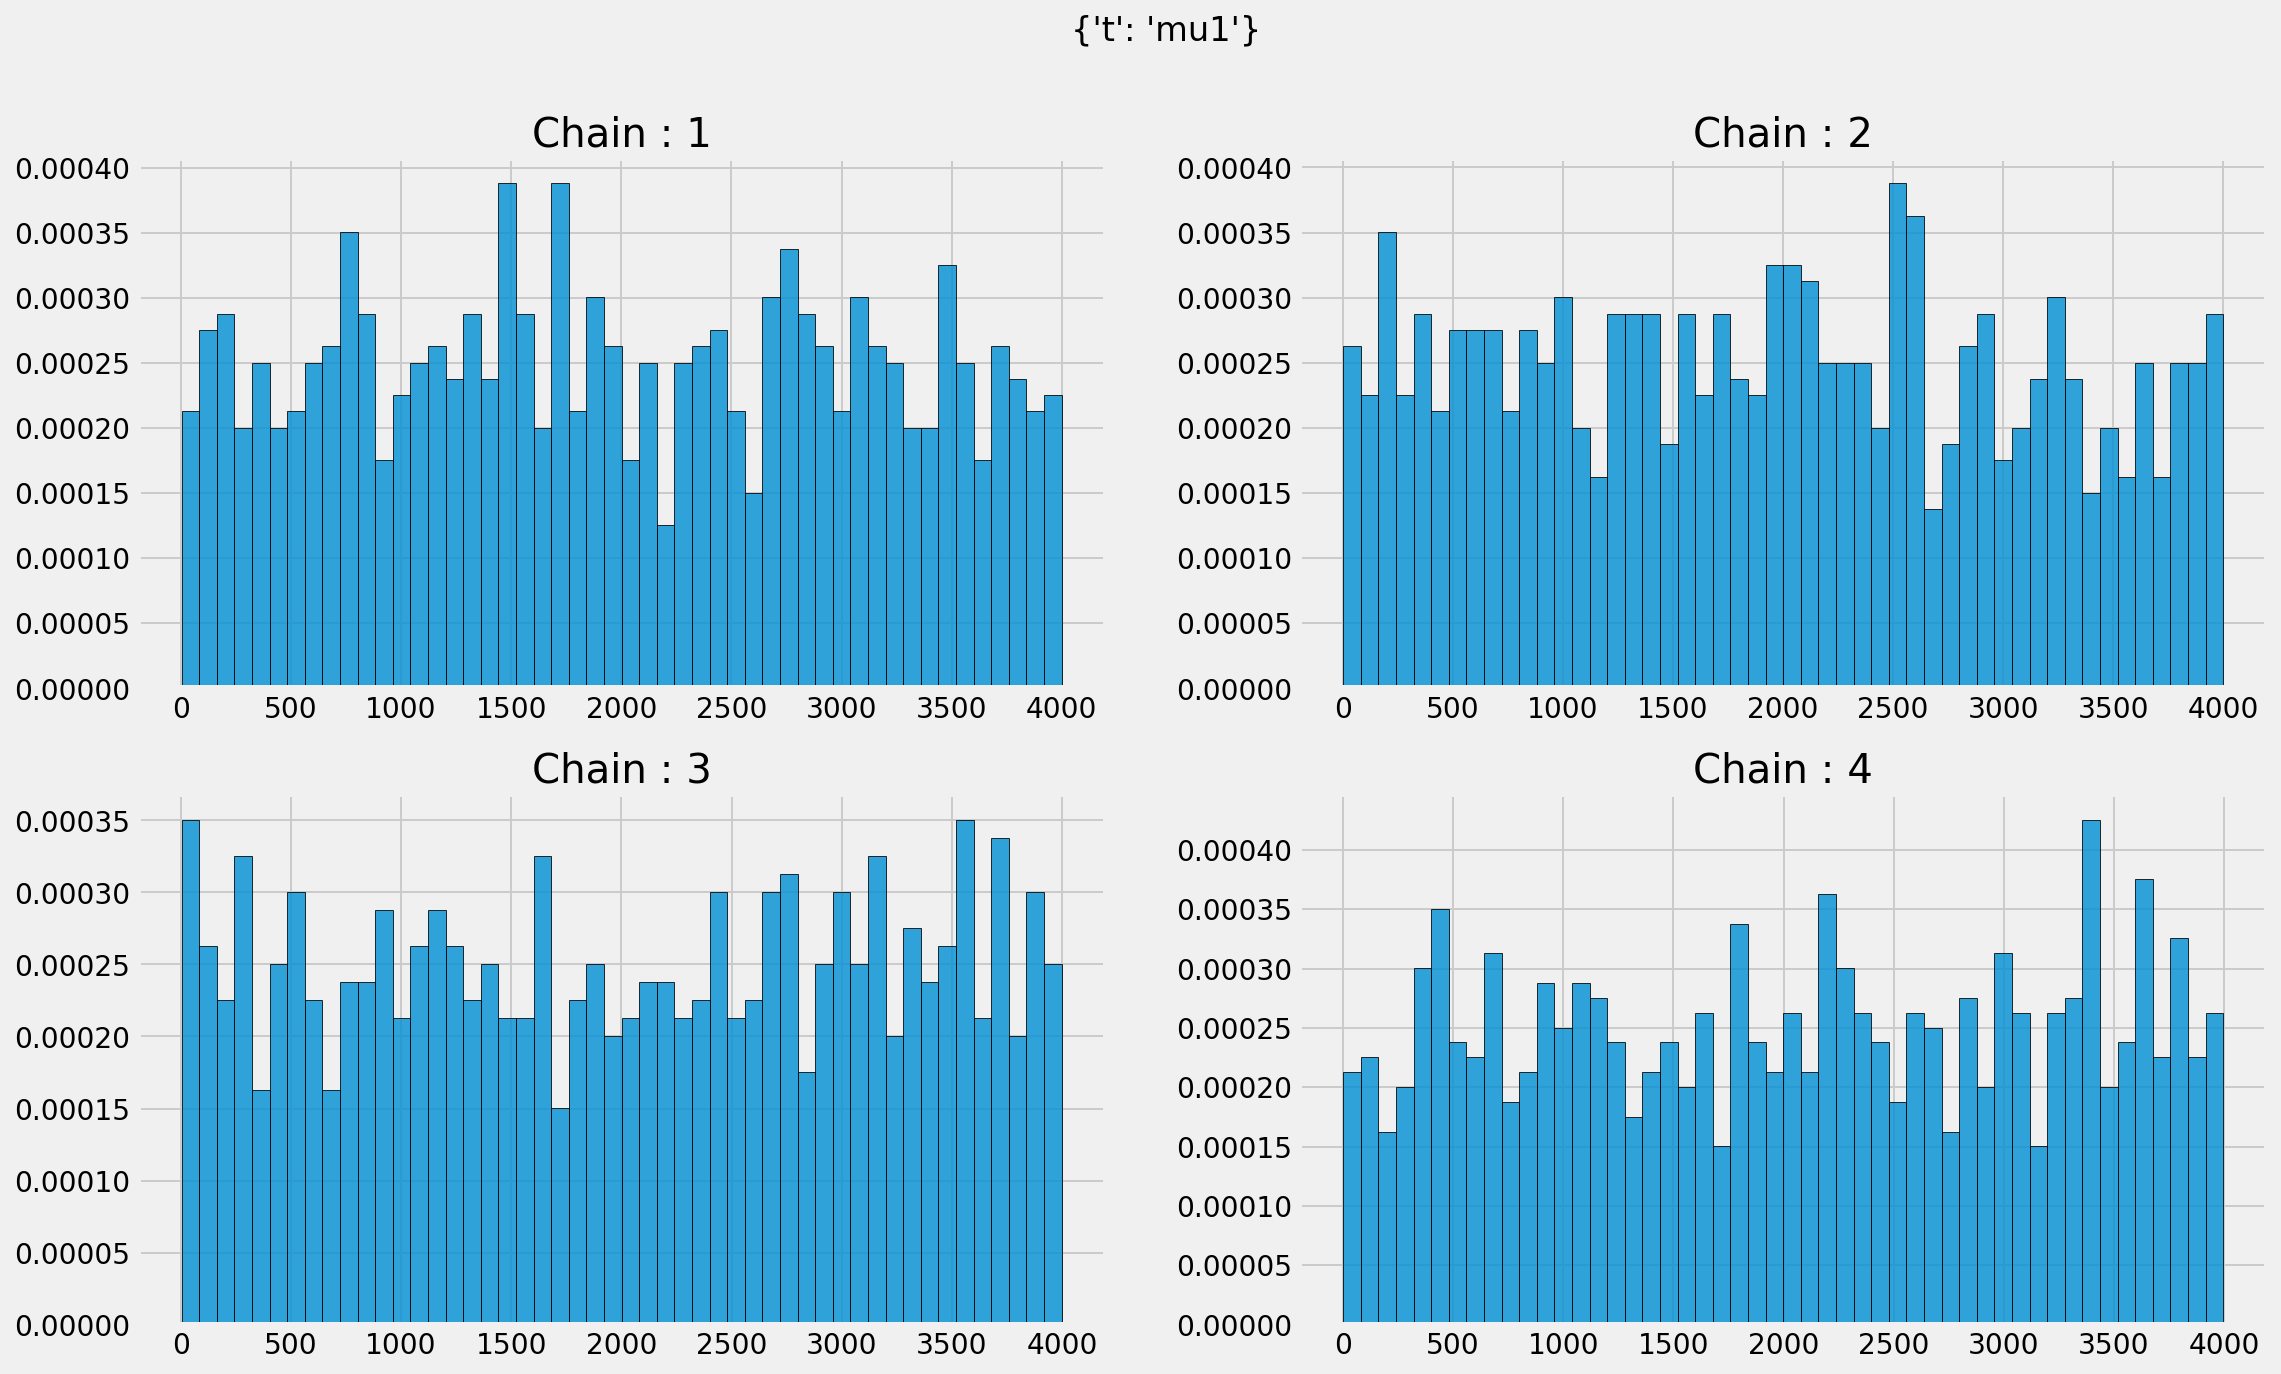

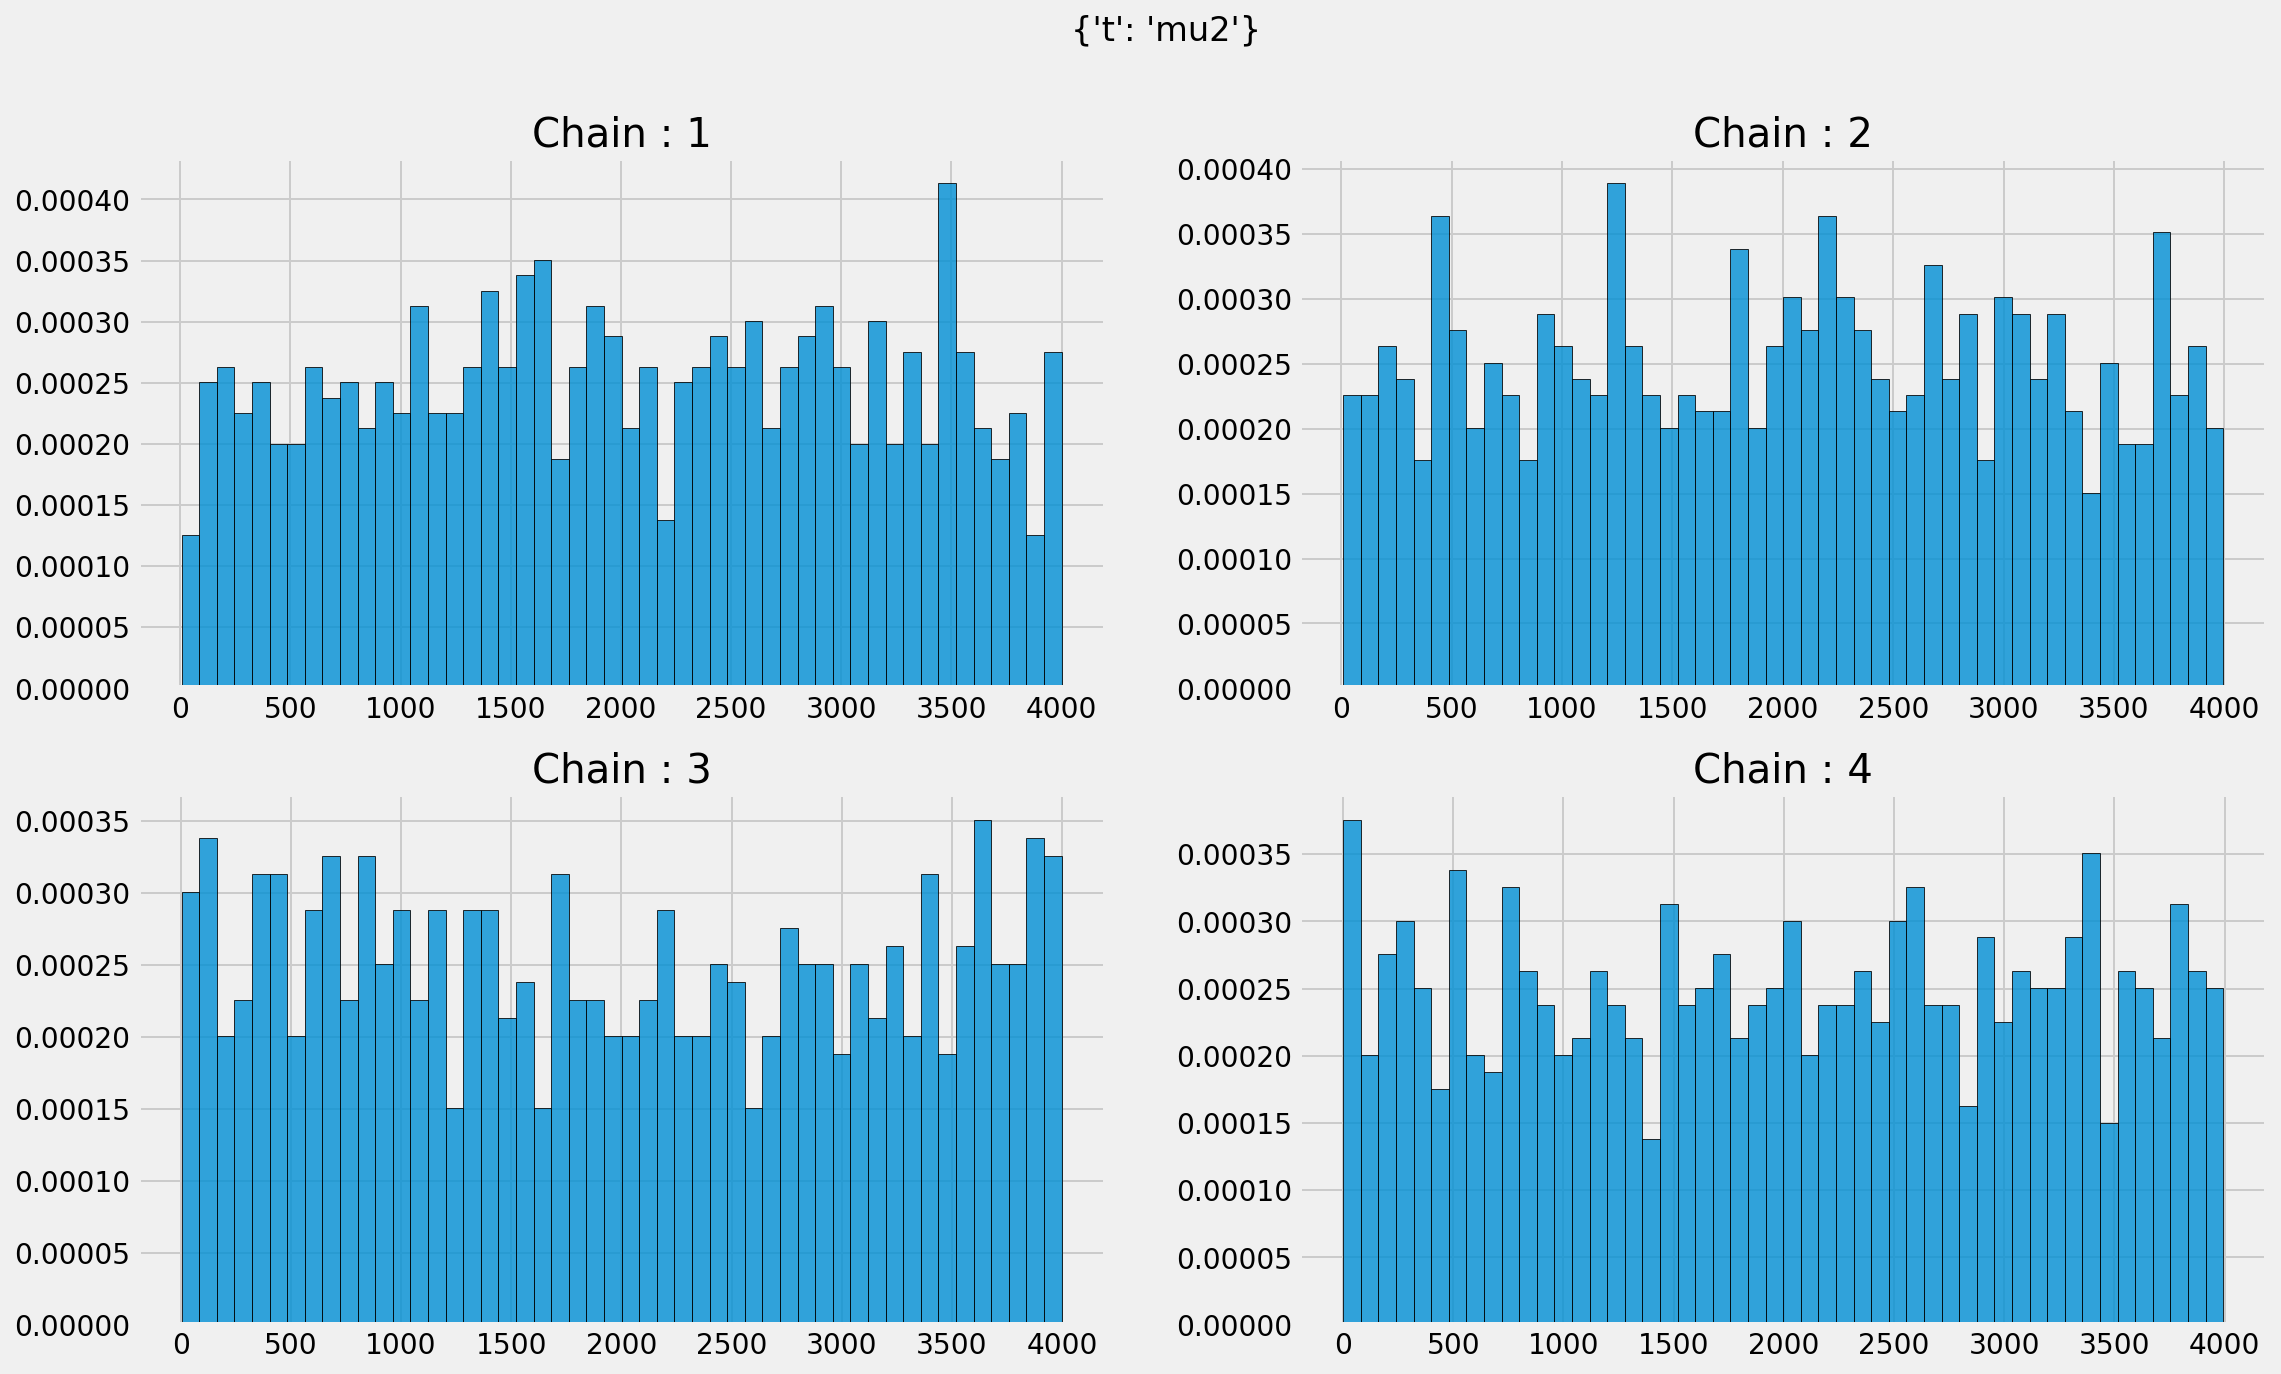

In [15]:
for i in range(trace_dvar.shape[2]):
    string = "mu" + str(i + 1)
    plotutils.rankplot(trace_dvar[:,:,i], 4, 2, 2, t = string)

The ranked chains do not look different for either of the features. Hence, even the rankplot is unable to diagnose this injection. This result makes sense given the definition of $\rhat$. The $\rhat$ statistic is calculated on a per parameter basis. So in a sense, it is a calculation over marginalization of chains and since the marginalization does not carry any information of correlation, the statistic fails to understand this injection. Although this is beyond the scope of our project, we think that implementing an $\rhat$ definition that encapsulates all the parameters in all the chains to yield a single number could be a good way to probe correlationness, in addition to calculating $\rhat$ by parameters. Of course, the alternative is to look at correlation plots of chains by parameter but that can quickly become cumbersome as we scale the number of parameters and chains.  

## Case 2: Injecting a fake chain with a different covariance matrix

Now we will try injecting a chain from a completely different Gaussian with a different covariance matrix, both in diagonal and off-diagonal terms.

The fake Gaussian looks like this:

<Figure size 1080x720 with 0 Axes>

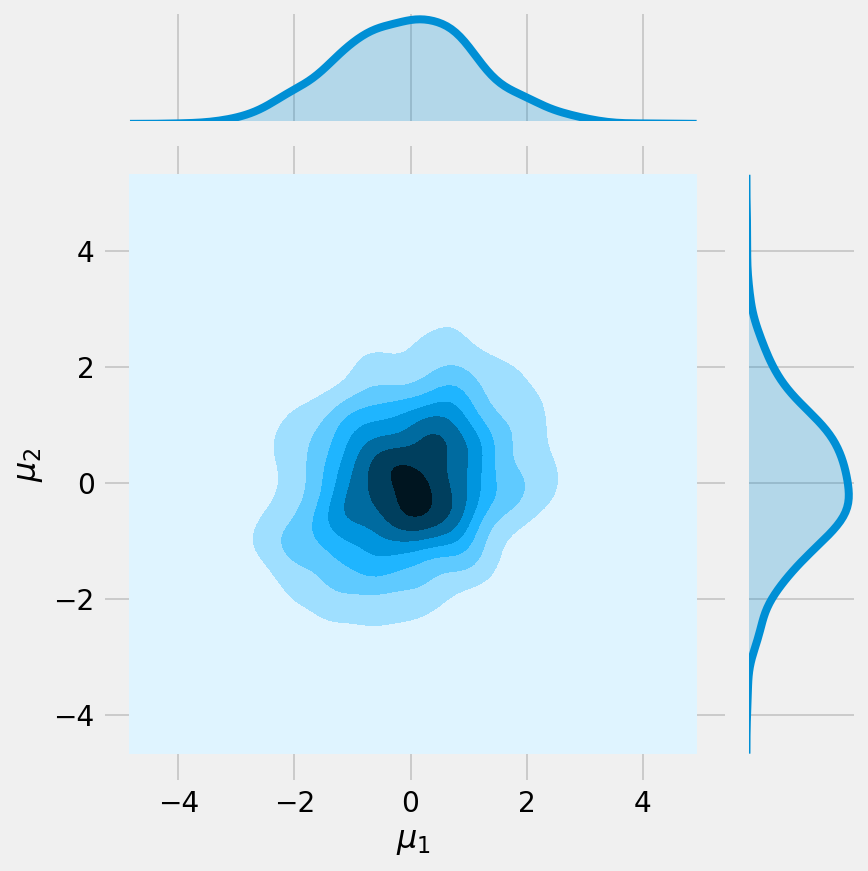

In [16]:
import seaborn as sns
seed = 42
np.random.seed(seed)
mean = np.array([0, 0])
sigma_fake = np.array([[1.5, .5], [.5, 1.5]])
data_fake = np.random.multivariate_normal(mean = mean, cov = sigma_fake, size=10_00)

fig = plt.figure(figsize=(15, 10))
f = sns.jointplot(data_fake[:,0], data_fake[:,1], kind = 'kde')
f.set_axis_labels(r'$\mu_1$', r'$\mu_2$', fontsize=16)

We will now sample points with this fake model:

In [17]:
params = ["mu"] # parameters to fit for
with pm.Model() as model_fake:
    mu = pm.MvNormal(params[0], mean, sigma_iso, shape = 2)
    y_obs = pm.MvNormal("y_obs", mu, cov=sigma_fake, observed=data_isotropic)

with model_fake:
    trace_fake = pm.sample(1_000, chains=2, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:15<00:00, 264.06draws/s]


Now, we inject the fake chain:

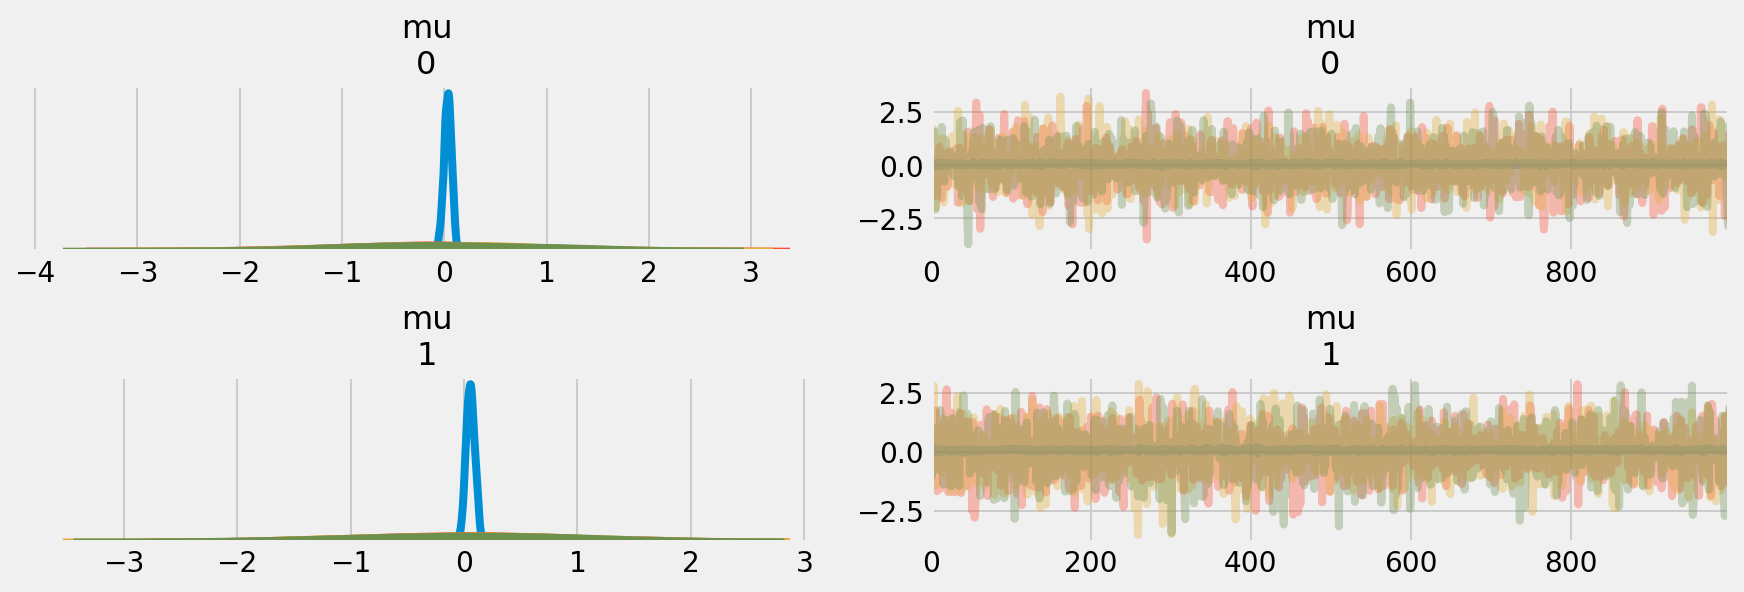

In [18]:
# extract trace array from pymc3's MultiTrace object
trace_dvar = np.array(trace_isotropic.get_values(params[0], combine=False)) 
# replace third chain of trace array with the fake chain
trace_dvar[0, :] = np.array(trace_fake.get_values(params[0], combine=False))[0, :]

trace_dvar_dict = {params[0]:trace_dvar}
pm.traceplot(trace_dvar_dict)
plt.show()

The left side plots show clearly that the fake chain exists. But for multidimensional models, it might not be that feasible to do this type of visualization. Moreover, the traceplots give the impression that the chains are well mixed.

In [19]:
trace_iso_injected_diff = {}
for i in range(trace_dvar.shape[2]):
    string = "mu" + str(i + 1)
    trace_tmp = trace_dvar[:,:,i]
    trace_iso_injected_diff[string] = trace_tmp
    
rhat_results(trace_iso_injected_diff)

,mu1,mu2
standard,1.000719,0.999890
split,1.000206,1.001400
ranked,1.000733,1.001132
folded,1.426872,1.427727


Clearly, the folded $\rhat$ statistic is able to pick up the obvious difference which the traditional $\rhat$ statistics (standard and split) failed to identify.

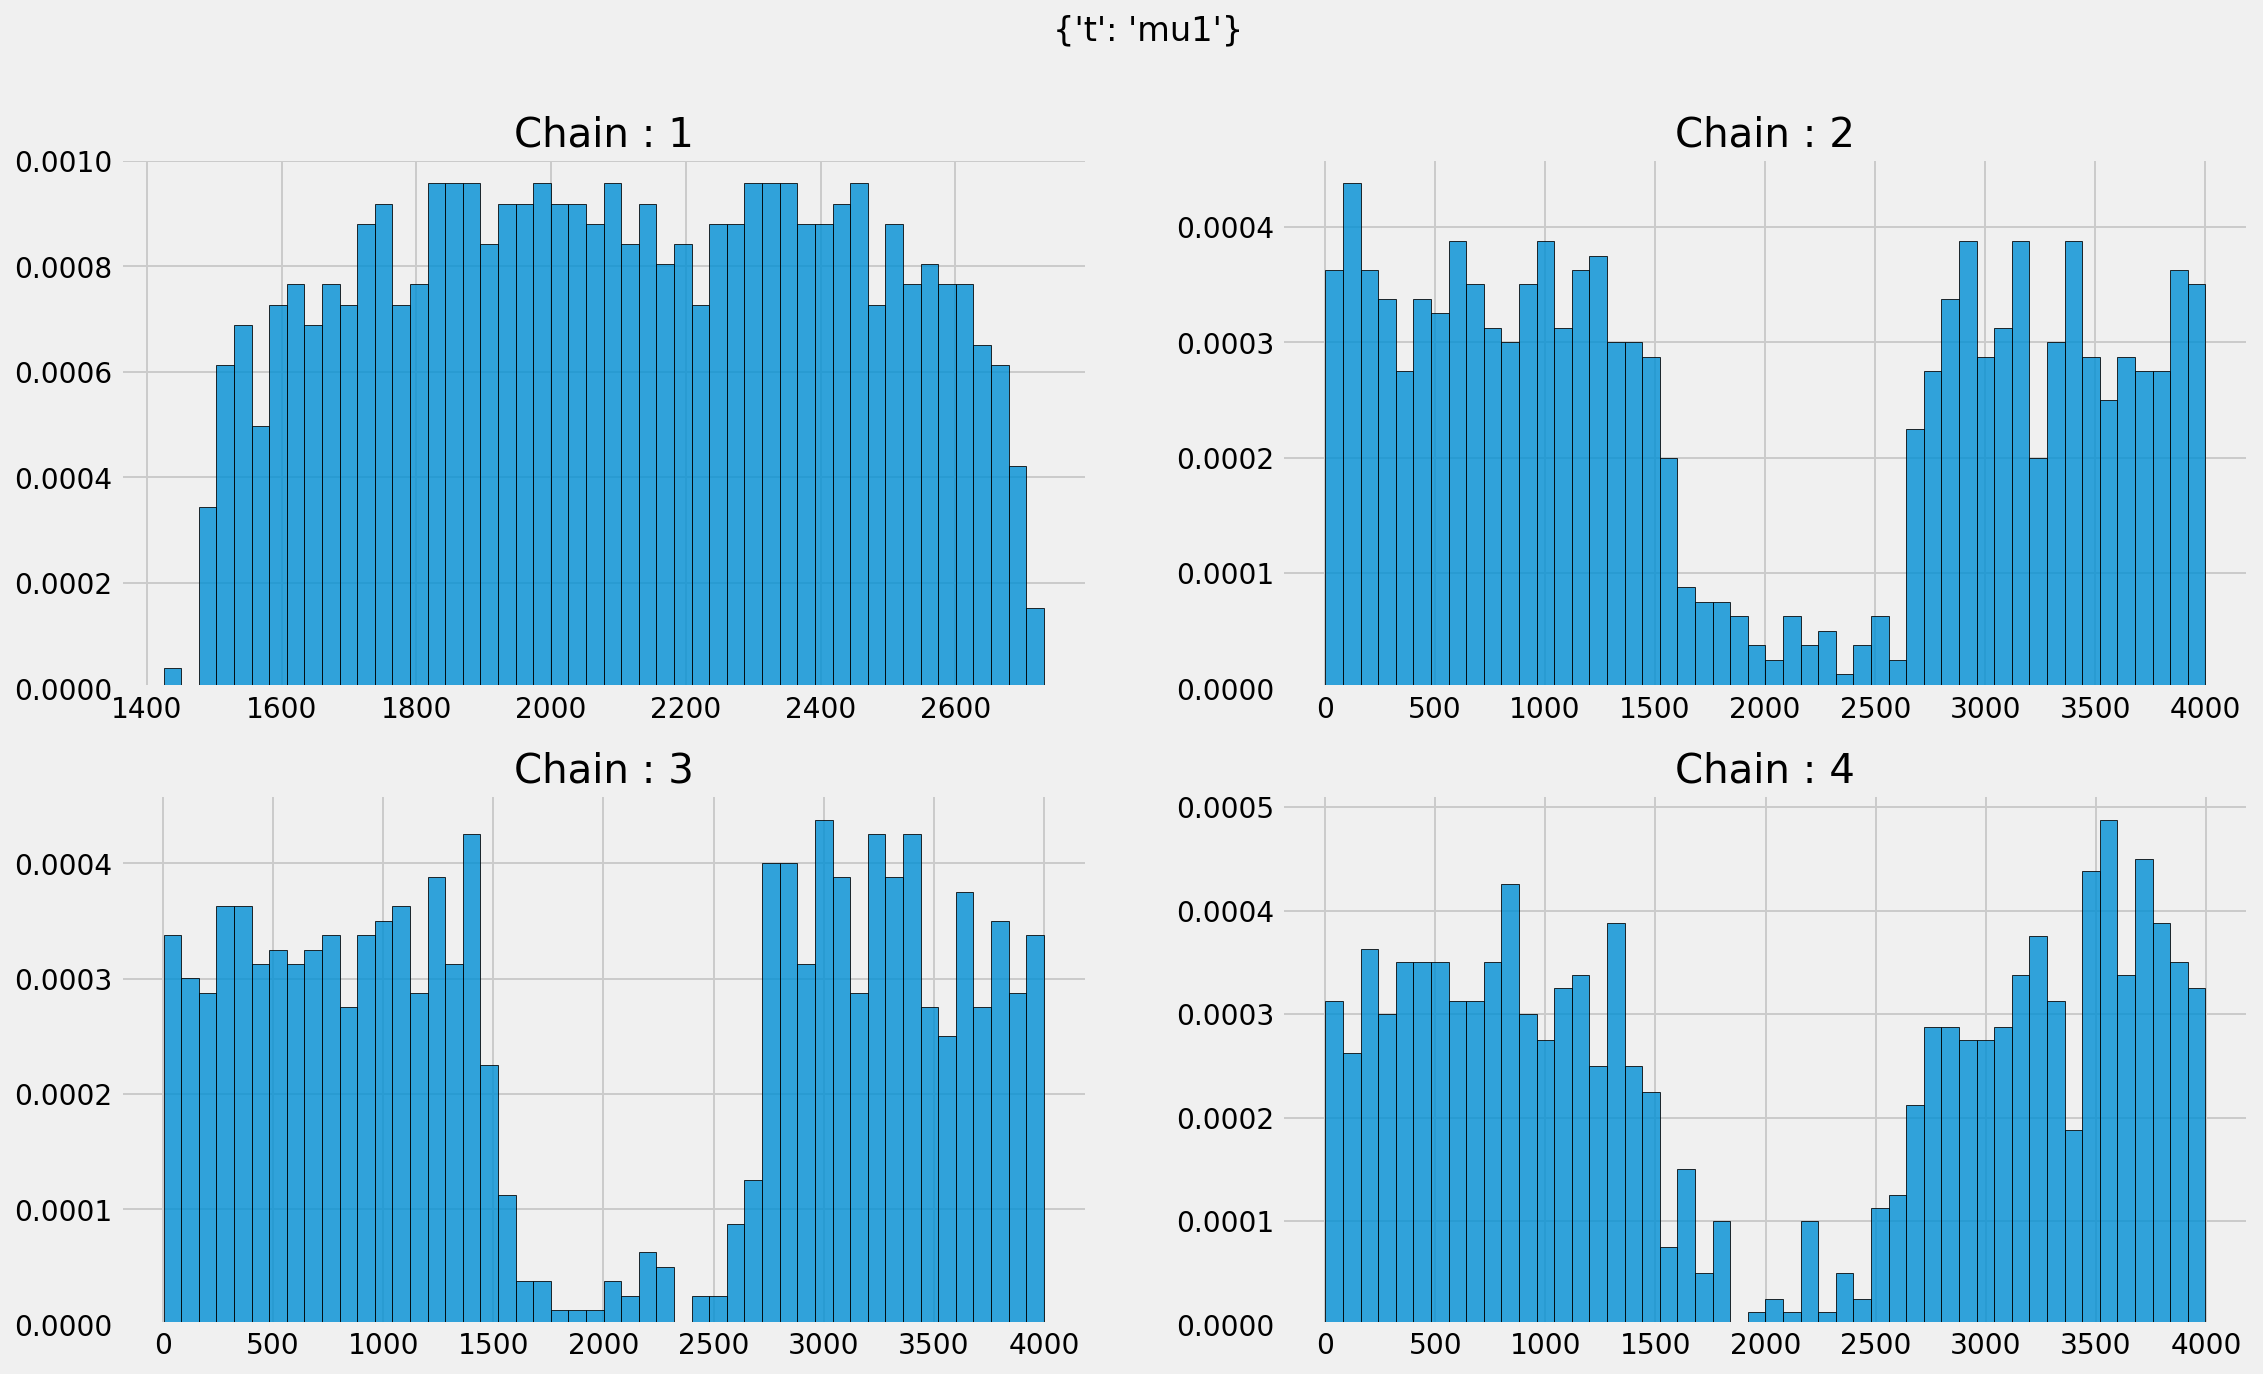

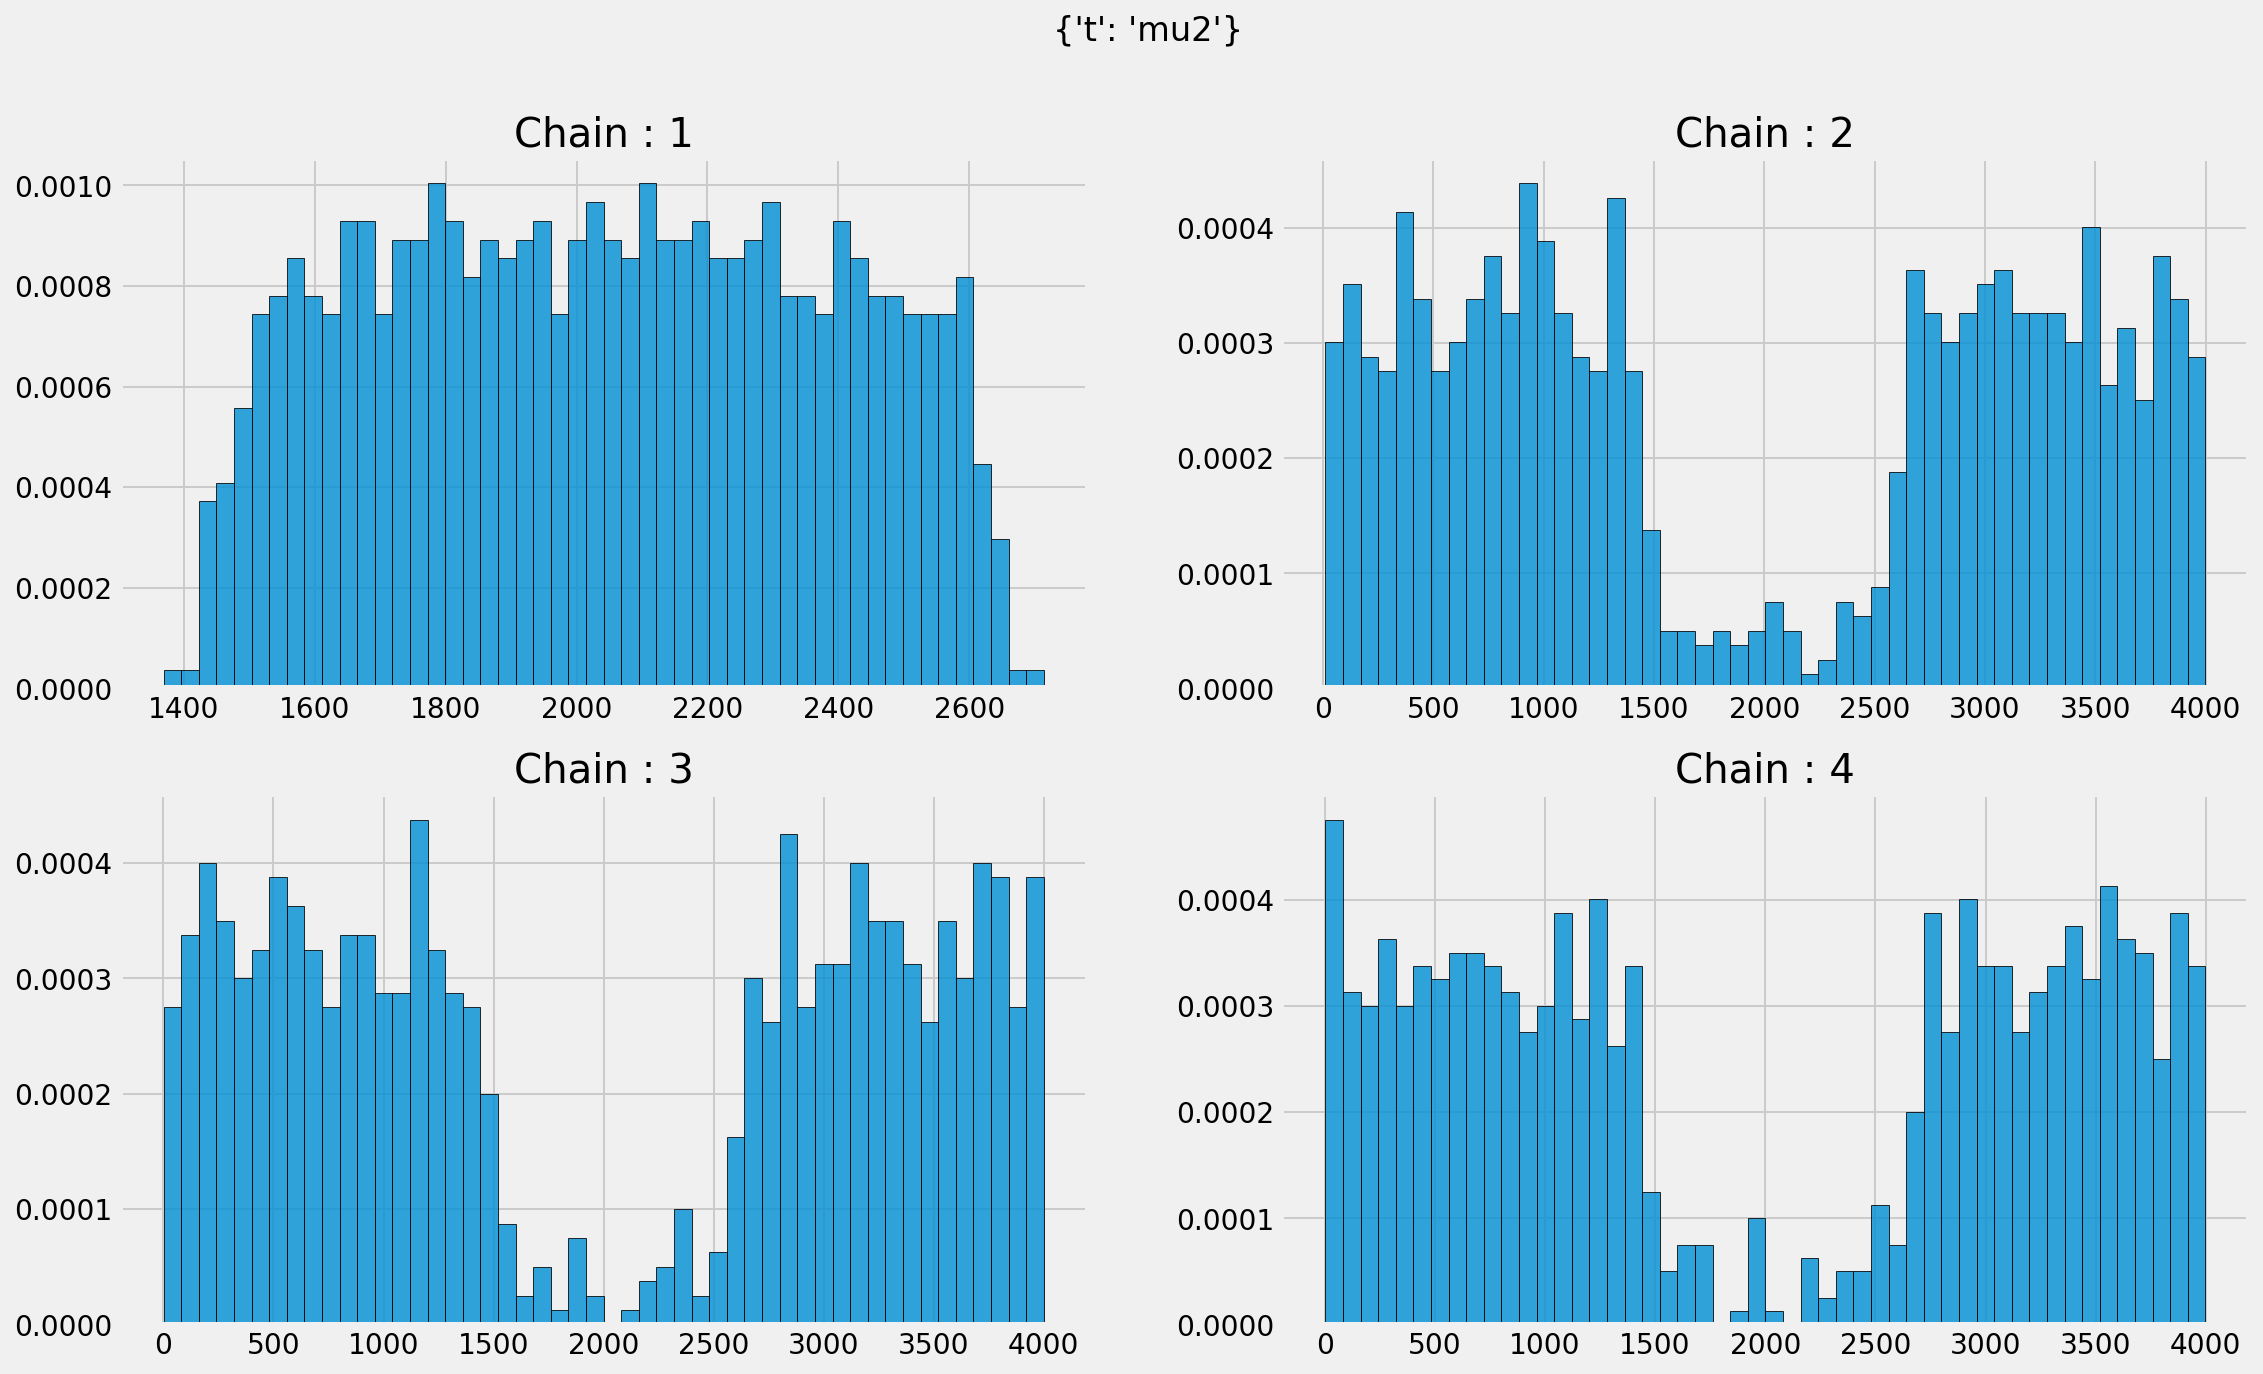

In [20]:
for i in range(trace_dvar.shape[2]):
    string = "mu" + str(i + 1)
    plotutils.rankplot(trace_dvar[:,:,i], 4, 2, 2, t = string)

The rankplots also show us that there is clearly something different with Chain $1$ compared to the other ones. 

# Conclusion

We have shown two cases with two different fake chains to understand whether the the newly defined $\rhat$ statistic and rankplot are robust against these scenarios. We see that the off-diagonal terms do not influence these diagnostics at all. This result makes sense because $\rhat$ statistic is calculated on a per parameter basis. For future work, we suggest that a single $\rhat$ metric be defined that takes all parameters into account and is robust against changes in off-diagonal terms of covariance matrices.

On the other hand, the diagnostics is very robust against changes in diagonal terms. In conclusion, we recommend the ranked and folded ranked $\rhat$ statistics and rankplot diagnostics because they are more robust against traditional methods, but one still needs to understand that there might be correlations that these tools will not probe.